In [1]:
kk.<phi> = NumberField(x^2 - x - 1, embedding=1.6)

In [2]:
import itertools
ico_vertices = []
for (s1, s2) in itertools.product([-1,1], [-1,1]):
    ico_vertices.append(tuple([0, s1, s2*phi]))
    ico_vertices.append(tuple([s1, s2*phi, 0]))
    ico_vertices.append(tuple([s2*phi, 0, s1]))

ico_edges = Set([(u,v) for u,v in itertools.combinations(ico_vertices, 2) if norm(vector(v)-vector(u)) == 2])

ico_faces = []
for u,v,w in itertools.combinations(ico_vertices, 3):
    if (u,v) in ico_edges and (v,w) in ico_edges and (u,w) in ico_edges:
        # i think we compute (uv x uw) dot u.  it should be positive.  If not, swap v and w.
        vu = vector(u)
        vv = vector(v)
        vw = vector(w)
        test = (vv-vu).cross_product(vw-vu).dot_product(vu)
        if test > 0:
            ico_faces.append((u,v,w))
        else:
            ico_faces.append((u,w,v))
        
ico_incidences = {v:[u for e in ico_edges for u in e if (v in e and v != u)] for v in ico_vertices }

ico_stars = []

for v in ico_vertices:
    star = []
    for u,w in itertools.combinations(ico_incidences[v], 2):
        f = tuple(sorted([u,v,w]))
        if f in ico_faces:
            star.append(f)
    ico_stars.append(star)

def center(face):
    return sum(vector(u) for u in face)/3
        
def faces_adjacent(f1, f2):
    return len([u for u in f1 if u in f2]) == 2





In [3]:
def subdivision_vertex(a,b,c,ca,cb,cc,k, correct_abberation = True):

    v = tuple((ca*a + cb*b + cc*c)/k)


    tau = 1/20
    # correct for spherical abberation, see below
    if(correct_abberation):
        if(ca == 0 and cb != 0 and cc != 0):
            mid = b/2+c/2
            v = tuple((1-tau) * vector(v) + tau * mid)
        elif(cb == 0 and ca != 0 and cc != 0):
            mid = a/2 + c/2
            v = tuple((1-tau)* vector(v) + tau * mid)
        elif(cc == 0 and ca != 0 and cb != 0):
            mid = a/2+b/2
            v = tuple((1-tau) * vector(v) + tau * mid)
        elif(ca != 0 and cb != 0 and cc != 0):
            mid = a/3+b/3+c/3
            v = tuple((1-tau) * vector(v) + tau * mid)
    return v
                
                
def ico_subdivide(k):
    vertices = set()
    faces = set()
    i1 = vector([1,-1,0])
    i2 = vector([1,0,-1])
    IV = IntegerVectors(k, 3)
    for (a,b,c) in ico_faces:
        for (ca, cb, cc) in IV:
            a = vector(a)
            b = vector(b)
            c = vector(c)
            v = subdivision_vertex(a,b,c,ca,cb,cc,k)
            
            vertices.add(v)
            
            u_idx = (ca-1, cb, cc+1)
            if u_idx in IV:
                #u = tuple(((ca-1)*a + cb*b + (cc+1)*c)/k)
                u = subdivision_vertex(a,b,c, ca-1, cb, cc+1, k)
                w_idx = [ca-1, cb+1, cc]
                if w_idx in IV:
                    #w = tuple(((ca-1)*a + (cb+1)*b + cc*c)/k)
                    w = subdivision_vertex(a,b,c,ca-1,cb+1, cc, k)
                    faces.add((v,w,u))
                w_idx = [ca, cb-1, cc+1]
                if w_idx in IV:
                    #w = tuple((ca*a + (cb-1)*b + (cc+1)*c)/k)
                    w = subdivision_vertex(a,b,c,ca,cb-1,cc+1, k)
                    faces.add((v,u,w))                                    
    return (vertices, faces)

(vertices_sub,faces_sub) = ico_subdivide(7)

vert_ordered = list(vertices_sub)
vert_lookup = {v:i for (i,v) in enumerate(vert_ordered)}


faces_by_idx = [[vert_lookup[u] for u in F] for F in faces_sub]

projected_vertices = []
for v in vert_ordered:
    #v_norm = vector(u.n(1000) for u in v).normalized()
    v_norm = vector(v).normalized()
    projected_vertices.append(v_norm)

I've decided I want to dualize this thing - but sage chokes when I ask it to do that for some reason to do with an underlying library.  As such I think I'll just do it by hand.  


Apparently all I need are the vertices of the dual structure.  There is one per face F.  Given vertices a,b,c in F, taken as vectors, the plane normal to a is the set of points x such that
$(x - a) \cdot a = 0$, or $x \cdot a = a \cdot a$.  Putting this and the two equations for b, c in a matrix, we have the system

$$
\left[
\begin{array}{ccc|c}
a_0 & a_1 & a_2 & a \cdot a \\
b_0 & b_1 & b_2 & b \cdot b \\
c_0 & c_1 & c_2 & c \cdot c
\end{array}
\right]
$$

which is basially guaranteed to be nonsingular unless I really screwed up, so when I row reduce it the coordinates for x appear in the last column, negated.

But, I found when I do this, I get very numerically bad answers!  I suspect the reason is that all of the matrices that I set up as above are horribly conditioned - I'm trying to intersect a bunch of near-parallel planes.  

Instead, let's leave the first equation alone, but replace the last two.  The dual vertex x above face F=(a,b,c) is also on the perpendicular bisecting plane of ab (essentially since a, b lie on a sphere, there's a similar triangles thing going on) and of ac.  

The perpendicular bisector of $ab$ is the plane through $(a+b)/2$ with normal vector $(b-a)$ - i.e. it has the equation

$$\left(x - \frac{a+b}{2}\right) \cdot (b-a) = 0$$

or

$$x \cdot (b-a) = \frac{a+b}{2} \cdot (b-a) = \frac{1}{2}(b \cdot b - a \cdot a)$$

... and this is just as horribly conditioned, isn't it?  I can obtain this equation by a simple row operation from the first matrix?  Except there's a bonus factor of 1/2 in there and I don't see why.

Hm.  Well, in that case, maybe I am just supposed to use high precision arithmetic, cross my fingers, and hope?  Well, even that appears not to work very well.  I guess I could use exact arithmetic... what a disaster... well, let's try.






In [4]:
dual_vertices = []
for i,idx in enumerate(faces_by_idx):
    vertices = (vector(projected_vertices[u]) for u in idx)
    entries = [list(u) + [u.dot_product(u)] for u in vertices]
    M = matrix(entries)
    x = M.rref().column(3)
    dual_vertices.append(x)


This is just going to look like a ball, but, oh well.

In [5]:
polygons3d(faces_by_idx, [[float(u) for u in v] for v in projected_vertices])

Graphics3d Object

Unless I make half the triangles red, that is...

In [6]:
polygons3d(faces_by_idx[:400], [[float(u) for u in v] for v in projected_vertices], color="blue") + \
polygons3d(faces_by_idx[400:], [[float(u) for u in v] for v in projected_vertices], color="red")

Graphics3d Object

In [7]:
approximate_dual_vertices = [[float(u) for u in v] for v in dual_vertices]

In [8]:
point3d(approximate_dual_vertices)
#line([i, vector(v).norm()] for (i,v) in enumerate(approximate_dual_vertices))



Graphics3d Object

omg, that was literally what I needed to do.  It is is crazy how hard this structure is to describe!  OK, well, after all THAT, I definitely want to make a model of this exact structure.

How to do that?  Well, I guess I need to unfold this thing.  My dual points correspond to faces in the primal polyhedron.  I need dual *faces* and those are going to correspond to points in the primal polyhedron.  

i.e.  I need a function to retrieve the dual face (list of 5 or 6 vertices) above a primal point; I need a function to draw that object in the plane, and then I need some explicit spanning tree of one twelfth of the primal graph (which has dodecahedral symmetry).  

To retrieve the dual face above a primal vertex v: I first find the 5/6 vertices in the star of v (everyone v is connected to), then find the corresponding faces in the big list of primal faces.  I do this on the non-normalized data.

To get the star or a primal vertex: that is the same as the adjacency information of the original graph - such info is encoded in vertices_sub, faces_sub.  Those are sets, and vert_ordered is the corresponding list, for index lookup.

Note: I can look up primal faces according to their barycenter - that way I don't need to worry about what order I wrote down their vertices in.

Coincidentally once I've implemented face lookups then I can make a 3d model of the desired polyhedron without recourse to sage's convex hull routines, which seems like a nice intermediary result.

In [9]:
def adjacency(vertices, faces):
    adjacency = {}
    for f in faces:
        for v,w in itertools.permutations(f, int(2)):
            if v not in adjacency:
                adjacency[v] = set()
            adjacency[v].add(w)
    return adjacency
    
adj = adjacency(vertices_sub, faces_sub)

def find_barycenters(faces_sub):
    barycenters = []
    for f in faces_sub:
        barycenter = sum(vector(v) for v in f)/3
        barycenters.append(tuple(barycenter))
    return barycenters

barycenters = find_barycenters(faces_sub)            
            

#barycenters = [sum(vector(u))/3 for u in faces_sub]



In [10]:
barycenters_lookup = {j:i for (i,j) in enumerate(barycenters)}
from collections import defaultdict

def face_above_primal_vertex(idx):
    v = vector(vert_ordered[idx])
    unordered_star = list(adj[vert_ordered[idx]])
    primal_star_traverse = defaultdict(list)
    for a,b in itertools.combinations(unordered_star, 2):
        barycenter = tuple((v+vector(a)+vector(b))/3)
        if barycenter in barycenters_lookup:
            primal_star_traverse[a].append(b)
            primal_star_traverse[b].append(a)
    a = unordered_star[0]
    b = primal_star_traverse[a][0]
    ordered_star = [a]
    while b != ordered_star[0]:
        ordered_star.append(b)
        next_vertices = primal_star_traverse[b]
        c = [u for u in next_vertices if u != a][0]
        (a,b) = (b,c)
    a = vector(ordered_star[0])
    b = vector(ordered_star[1])
    c = vector(ordered_star[2])
    if (a-b).cross_product(c-b).dot_product(b) < 0:
        ordered_star = list(reversed(ordered_star))
    dual_face = []
    for i in range(len(ordered_star)):
        a = vector(ordered_star[i])
        b = vector(ordered_star[i-1])
        barycenter = tuple((a+b+v)/3)
        dual_face.append(barycenters_lookup[barycenter])
    return dual_face
    
    

In [11]:
dual_faces = [face_above_primal_vertex(i) for i in range(len(vert_ordered))]

I guess this is just gonna look like a ball.

In [12]:
polygons3d(dual_faces, approximate_dual_vertices)

Graphics3d Object

...unless I just randomly color the first half the faces red!  

In [13]:
polygons3d(dual_faces[:250], approximate_dual_vertices,color="blue") + \
polygons3d(dual_faces[250:], approximate_dual_vertices,color="red")

Graphics3d Object

Haha, that's awesome and I win.

Next: decompose as a dodecahedron - find all the primal vertices within a certain distance of one of the icosahedron vertices.

In [14]:
def cap(k, which_cap=0):
    cap_vertices = set()
    IV = IntegerVectors(k, 3)
    for (a,b,c) in ico_faces:
        if a == ico_vertices[which_cap]:
            for (ca, cb, cc) in IV:
                if cb <= ca and cc < ca:
                    a = vector(a)
                    b = vector(b)
                    c = vector(c)
                    #v = tuple((ca*a + cb*b + cc*c)/k)
                    v = subdivision_vertex(a,b,c,ca,cb,cc,k)
                    cap_vertices.add(v)
        if b == ico_vertices[which_cap]:
            for (ca, cb, cc) in IV:
                if cc <= cb and ca < cb:
                    a = vector(a)
                    b = vector(b)
                    c = vector(c)
                    #v = tuple((ca*a + cb*b + cc*c)/k)
                    v = subdivision_vertex(a,b,c,ca,cb,cc,k)
                    cap_vertices.add(v)
        if c == ico_vertices[which_cap]:
            for (ca, cb, cc) in IV:
                if ca <= cc and cb < cc:
                    a = vector(a)
                    b = vector(b)
                    c = vector(c)
                    #v = tuple((ca*a + cb*b + cc*c)/k)
                    v = subdivision_vertex(a,b,c,ca,cb,cc,k)
                    cap_vertices.add(v)
    return [vert_lookup[v] for v in cap_vertices]


colors = ["brown", "black", "red", "orange", "yellow", "green", "blue", "purple", "grey", "white", "silver", "gold"]


pics = []
for t in range(12):
    cap_idx = cap(7,t)            
    patch_faces = [dual_faces[i] for i in cap_idx]
    pics.append(polygons3d(patch_faces, approximate_dual_vertices, color=colors[t]))
    
sum(pics)

Graphics3d Object

In [15]:
cap_idx = cap(7)
patch_faces = [dual_faces[i] for i in cap_idx]
patch_edges = [[approximate_dual_vertices[j] for j in face + [face[0]]] for face in patch_faces ]
sum(line(p) for p in patch_edges)

Graphics3d Object

Okay that continues awesome.  Now I need to take one of those caps and flatten it out.  I think the general idea is going to be as follows:

- pick an explicit rooted spanning tree for the part of primal graph underlying the cap.
- describe each face as an alternating list of lengths and angles
- write a piece of code to place a face in the plane, starting at a given edge in a given orientation
- place the root face in the plane
- traverse the tree, placing one face at a time: remove the shared edge (placing it in a list) and add the others

Note that spanning tree edges should wind up being dual to shared edges between two faces.

Note: any closed curve in the plane can be described as a list of alternating lengths and angles.  Indeed, if you don't assume that the list is *alternating*, then it's easy to join two faces along their common edge:  add a 180 degree rotation after the edge in the first polygon, then do the second polygon, then add another 180 degree rotation and continue.

This gives an algorithm for simultaneous tree traversal and dual graph traversal.  First, figure out which of the edges in the dual figure are dual to tree edges and which ones are not.  Then, start at a vertex at the root face and:
 - If the edge you're going to walk down is tree, don't - instead, step to the corresponding next face in the tree.
     - The angle you turn is: the angle you were going to turn, plus 180, plus the corresponding angle in the next face.  Since that's a big angle, though, maybe what I really mean is that minus 360 degrees, which is a negative angle (i.e. a turn in the opposite direction).  i.e. I'm subtracting 180, not adding it.
 - If the edge you're going to walk down is not a tree edge, then just do it.

We'll just do cap zero - the one going with the zeroth icosahedron vertex.  that one's easier because the central vertex is always "a" in the integer vector iterator.


In [38]:
def cap_tree(k):
    cap_vertices = set()
    cap_edges = set()
    IV = IntegerVectors(k, 3)
    for (a,b,c) in ico_faces:
        if a == ico_vertices[0]:
            for (ca, cb, cc) in IV:
                if cb <= ca and cc < ca:
                    a = vector(a)
                    b = vector(b)
                    c = vector(c)
                    #v = tuple((ca*a + cb*b + cc*c)/k)
                    v = subdivision_vertex(a,b,c,ca,cb,cc,k)
                    cap_vertices.add(v)
                    
                    if ca != k:
                        if cc == 0:
                            #w = tuple(((ca+1)*a + (cb-1)*b + cc*c)/k)
                            w = subdivision_vertex(a,b,c,ca+1,cb-1,cc, k)
                        else:
                            #w = tuple(((ca+1)*a + cb*b + (cc-1)*c)/k)
                            w = subdivision_vertex(a,b,c,ca+1,cb,cc-1,k)
                        cap_edges.add((v,w))
    return cap_vertices, cap_edges
                    
(tree_vertices,tree_edges) = cap_tree(7)

V_embed = [projected_vertices[vert_lookup[v]] for v in tree_vertices]
E_embed = [[projected_vertices[vert_lookup[v]], projected_vertices[vert_lookup[w]]] for (v,w) in tree_edges]

Okay, so here's my explicit spanning tree - I think this one will work - but everything was off by a minus sign.  So I went back in the code and deleted the minus sign on "x" and reran it.  Done!

In [39]:
sum(line(e, color="red") for e in E_embed) + sum(line(p) for p in patch_edges)



Graphics3d Object

All right, let's flatten this thing out.  First of all, we need code to translate between primal edges and dual edges.  The logic is the same.  Given a primal edge: its endpoints correspond to dual faces; find the common vertex.

The correspondence between primal faces and dual edges is easy: both things come in lists, and the order is the same. I should start with making lookup tables for both.  But also, I think I want versions of them that are just tuples.

In [28]:
dual_face_tuples = [tuple(u) for u in dual_faces]
primal_face_tuples = [tuple(u) for u in faces_by_idx]
dual_face_lookup = {j:i for (i,j) in enumerate(dual_face_tuples)}
primal_face_lookup = {j:i for (i,j) in enumerate(primal_face_tuples)}


def primal_edge_from_dual(e):
    a,b = e
    a_face = primal_face_tuples[a]
    b_face = primal_face_tuples[b]
    return tuple(set(a_face).intersection(set(b_face)))

def dual_edge_from_primal(e):
    a,b = e
    a_face = dual_face_tuples[a]
    b_face = dual_face_tuples[b]
    return tuple(set(a_face).intersection(set(b_face)))
    

In [42]:
tree_edge_tuples = [(vert_lookup[u], vert_lookup[v]) for (u,v) in tree_edges]

Given a dual face, and a vertex index within that face, we need to be able to compute: the exterior angle at that vertex (in the positive direction), and the length of the side beginning at that vertex (in the positive direction).

In [72]:
def exterior_angle(dual_face, idx):
    n = len(dual_face)
    next_vert = approximate_dual_vertices[dual_face[(idx+1) % n]]
    this_vert = approximate_dual_vertices[dual_face[idx]]
    prev_vert = approximate_dual_vertices[dual_face[idx-1]] # python does the right thing
    v = vector(this_vert) - vector(prev_vert)
    w = vector(next_vert) - vector(this_vert)
    return acos(v.dot_product(w) / v.norm() / w.norm())

def side_length(dual_face, idx):
    n = len(dual_face)
    next_vert = approximate_dual_vertices[dual_face[(idx+1) % n]]
    this_vert = approximate_dual_vertices[dual_face[idx]]
    return (vector(next_vert) - vector(this_vert)).norm()


This takes one step of the simultaneous tree-and-cap-traverse described above.  We keep track of where we are by (current dual face, current index).  We return the next such pair, together with the rotate-and-step move we used to get there, and (if appropriate) the rotate_and_step move that *would* have crossed a tree edge, had we taken it.

I decided, in debugging to change the algorithm slightly.  Always return the step.  If the step would have crossed the tree edge, though, say so.

In [114]:
def tree_cap_step(current_dual_face, current_idx):
    n = len(current_dual_face)
    
    
    rotation = exterior_angle(current_dual_face, current_idx)
    step_length = side_length(current_dual_face, current_idx)

    a = current_dual_face[current_idx]
    b = current_dual_face[(current_idx + 1) % n]
    (aprim, bprim) = primal_edge_from_dual((a,b))
    step_crossed_tree =  ((aprim, bprim) in tree_edge_tuples or (bprim,aprim) in tree_edge_tuples)
    if step_crossed_tree:
        current_dual_face_idx = dual_face_lookup[current_dual_face]
        if current_dual_face_idx == aprim:
            next_dual_face_idx = bprim
        elif current_dual_face_idx == bprim:
            next_dual_face_idx = aprim
        else:
            raise Exception("Something is wrong with my primal-dual graph structures")
        next_dual_face = dual_face_tuples[next_dual_face_idx]
        next_idx = next_dual_face.index(a)
    else:    
        next_dual_face = current_dual_face
        next_idx = (current_idx + 1) % n
            
    return next_dual_face, next_idx, rotation, step_length, step_crossed_tree

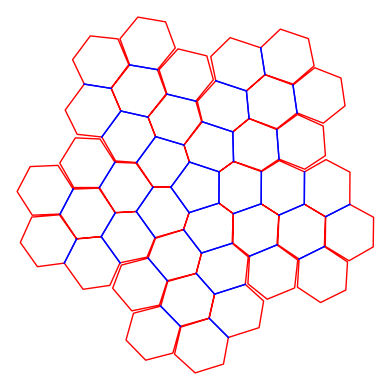

In [122]:
def traverse(start_face, start_idx):
    current_face = start_face
    current_idx = start_idx
    
    pos = vector((0,0))
    angle = 0
    
    bend_edges = []    
    contour = [pos]
    just_starting = True

    while(start_face != current_face or start_idx != current_idx or just_starting):
        just_starting = False
        current_face, current_idx, rotation, step_length, crossed_tree = tree_cap_step(current_face, current_idx)
        angle += rotation
        if crossed_tree:
            bend_update = step_length * vector((cos(angle), sin(angle)))
            bend_pos = pos + bend_update
            bend_edges.append((pos, bend_pos))
            angle -= float(pi)
        else:
            step_update = step_length * vector((cos(angle), sin(angle)))
            pos += step_update
            contour.append(pos)
    return contour, bend_edges
    
    
    
    

first_tree_vertex = tree_edge_tuples[0][0]
first_dual_face = dual_face_tuples[first_tree_vertex]
first_idx = 0

contour, bend_edges = traverse(first_dual_face, first_idx)
G = line(contour, color="red") + sum(line(e) for e in bend_edges)

G.save("mirrorball-cap.svg", aspect_ratio=1, axes=False)
G.show(aspect_ratio=1, axes=False)

And there it is.  Theoretically, if you cut on the red lines and score on the blue lines, you can assemble that into a cap - and then assemble 12 caps into the sphere.  Or, if you just want a dome, just use 6.

I am so good at hexagons.

# Aside: Spherical aberration

You know, as I was looking at that image, it is somehow much more obvious how small the inner pentagon is compared with the hexes around the edges.  That's not my favorite - I wonder if there is an easy way to move the primal points around.  I corrected for it in the "spherical aberration" code above - the reasoning for how that code works is here.



I guess the correction *could* happen during projection but it's actually easier if it happens during subdivision?  It should be something like: if i've got an integer vector (a,b,c), all nonzero, then I'm supposed to take a weak weighted average between that thing and (k/3, k/3, k/3) (moving the point towards the center of the primal face).  

If (say) b is zero, then I'm supposed to do a (I guess similar) weighted average between that point and (k/2, 0, k/2).  Note: If I do it all with rational arithmetic then I stay in the ring I'm working in and nobody is the wiser. 

I wonder what is the right weight to use.  I guess the point is to undo the distortion of projecting it to the sphere - perhaps it is easiest to think, then, of getting it right along an edge.  

Let's imagine k+1 points along a circular arc of angle theta, which is whatever angle you see at the center of an icosahedron between two vertices.  The points are equally spaced on the circle; we can use trigonometry to project them down to the chord subtended by that arc.  the zeroth and the kth point are actually in the right spot.  The others are near the k-1 middle points described above by the averaging procedure.  I want to choose the weight parameter so as to minimize the sum of squared errors between each point and its friend.




In [18]:
theta = float(2 * atan(1/phi))

k = 7

circle_points = [vector((cos(t*theta/k), sin(t*theta/k))) for t in range(0,k+1) ]



I found a stack overflow post with a nice clear way to intersect line segments.  In that post, we take p = the origin, q = (1,0), r = one of the points on the circle, and s = the vector from the 0th circle point to the kth.

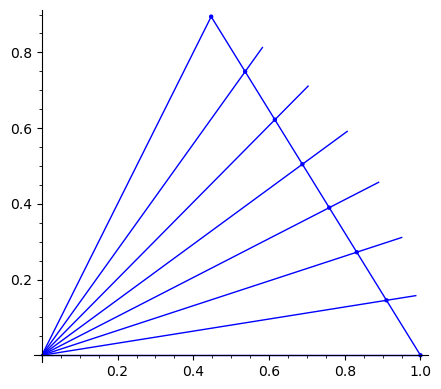

In [19]:

projected_points = [circle_points[0]]

def cross(v,w):
    return v[0]*w[1] - v[1]*w[0]

for i in range(1, k):
    p = vector((0,0))
    q = circle_points[0]
    r = circle_points[i]
    s = circle_points[k]-circle_points[0]
    t = cross(q-p, s) / cross(r,s)
    projected_points.append(t*r)
projected_points.append(circle_points[k])

G = sum(line([(0,0), pt]) for pt in circle_points)
G += point(projected_points)
G += line([circle_points[0], circle_points[k]])

G.show(aspect_ratio=1)


lookin' nifty.  So, those are my projected points.  And here are my approximated points:

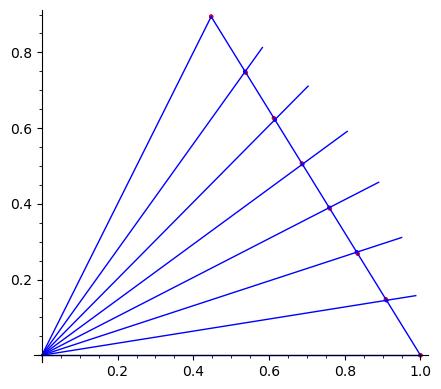

In [20]:
def approx_points(tau):
    p = circle_points[0]
    q = circle_points[k]
    mid = (p+q)/2
    pts = [p]
    for i in range(1, k):
        pts.append((1-tau) * ((k-i)/k*p + i/k * q) + tau*mid)
    pts.append(q)
    return pts

G = sum(line([(0,0), pt]) for pt in circle_points)
G += point(projected_points)
G += line([circle_points[0], circle_points[k]])
G += point(approx_points(0.06425391881966205), color="red")
G.show(aspect_ratio=1)
    

It looks, from eyeballing it, that about 0.05 is a good weight?  But why eyeball it when we have a whole computer algebra system here.  Let's just put in tau as a symbolic variable and minimize the sum of squared errors...  I get tau is about 0.064, nice.  That's the number I've put in above.

In [21]:
var("tau")
f = sum( (u-v).dot_product(u-v) for (u,v) in zip(approx_points(tau), projected_points) ).expand()

plot(f, (tau, 0, 0.2))

weight = float(solve(f.derivative(tau) == 0, tau)[0].right())
weight

0.06425391881966205

Now, I'm supposed to be doing a bunch of exact arithmetic involving this number, so I feel like I should get a good rational approximation to it - it seems that 1/16 is 0.0625.  That is good enough. That's the number I used in the spherical abberation correction code above.  But: I didn't love the results - the hexagons were all much more evenly sized, but way less regular.  I think I will use a smaller correction factor, maybe 1/20?

In [22]:
continued_fraction(weight).convergents()

[0,
 1/15,
 1/16,
 2/31,
 7/109,
 16/249,
 71/1105,
 87/1354,
 245/3813,
 332/5167,
 43737/680690,
 44069/685857,
 616634/9596831,
 3743873/58266843,
 11848253/184397360]

Here is a plot of the points, pre-normalization - you have to stare at it a bit, spin it around etc, but you can see they're more widely spaced near the icosohedron's corners.

In [23]:
point3d(vert_ordered)

Graphics3d Object